In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# plt.rcParams['figure.figsize'] = (20,20)


from PIL import Image

2024-05-20 12:12:50.822373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 12:12:51.628851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation

In [2]:
#directory
train_dir = 'BinaryPneumoniaBroncho/Train'
val_dir = 'BinaryPneumoniaBroncho/Test'

In [3]:
#visualize Image before Augmentation
train_pneumonia_img = glob(train_dir + '/Pneumonia/*.PNG') + glob(train_dir + '/Pneumonia/*.png') + glob(train_dir + '/Pneumonia/*.jpg') + glob(train_dir + '/Pneumonia/*.jpeg')
train_bronchopneumonia_img = glob(train_dir + '/Bronchopneumonia/*.PNG') + glob(train_dir + '/Bronchopneumonia/*.png') + glob(train_dir + '/Bronchopneumonia/*.jpg') + glob(train_dir + '/Bronchopneumonia/*.jpeg')

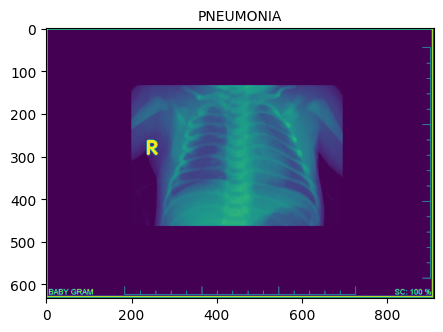

(633, 909)


In [4]:
pneumonia_img = Image.open(train_pneumonia_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
pneumonia_gray = pneumonia_img.convert('L')

pneumonia = np.asarray(pneumonia_gray)

plt.figure(figsize=(5, 5))
plt.title('PNEUMONIA', fontsize=10, color='black')
plt.imshow(pneumonia)
plt.show()

print(pneumonia.shape)

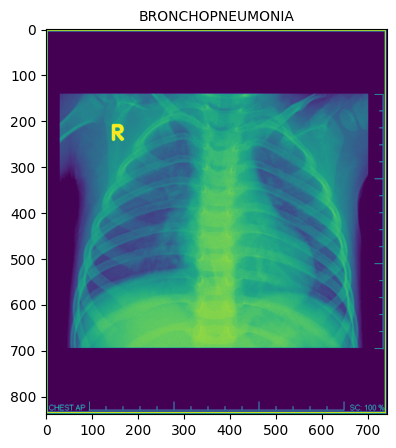

(839, 742)


In [5]:
bronchopneumonia_img = Image.open(train_bronchopneumonia_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
bronchopneumonia_gray = bronchopneumonia_img.convert('L')

bronchopneumonia = np.asarray(bronchopneumonia_gray)

plt.figure(figsize=(5, 5))
plt.title('BRONCHOPNEUMONIA', fontsize=10, color='black')
plt.imshow(bronchopneumonia)
plt.show()

print(bronchopneumonia.shape)

Data Preprocessing

In [6]:
from skimage import exposure

# Define a custom preprocessing function to adjust brightness and contrast
def adjust_brightness_contrast(image):
    # Adjust brightness and contrast using skimage
    image = exposure.adjust_gamma(image, gamma=1.08)  # Example gamma value, adjust as needed
    return image


In [7]:
#ImageDataGenerator for training and test
datagen = ImageDataGenerator(validation_split = 0.25,
                             rescale = 1./255,
                             preprocessing_function=adjust_brightness_contrast,
                             horizontal_flip = False,
                             vertical_flip = False)
#ImageDataGenerator for val set
# harusnya test_set
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_SIZE = (227,227)
train_set = datagen.flow_from_directory(train_dir,
                                        subset = 'training',
                                        classes = ['Pneumonia', 'Bronchopneumonia'],
                                        class_mode = 'binary',
                                        batch_size = 16,
                                        target_size = IMG_SIZE)

Found 81 images belonging to 2 classes.


In [9]:
# harusnya val_set
test_set = datagen.flow_from_directory(train_dir,
                                       subset = 'validation',
                                       classes = ['Pneumonia', 'Bronchopneumonia'],
                                       class_mode = 'binary',
                                       batch_size = 16,
                                       target_size = IMG_SIZE)

Found 26 images belonging to 2 classes.


In [10]:
# X_train, y_train = train_set.next()
# X_test, y_test = test_set.next()

In [11]:
for batch in train_set:
    X_train, y_train = batch
    break #Exit loop after processing the first batch

# harusnya val_set
for batch in test_set:
    X_test, y_test = batch
    break

In [12]:
print(len(X_train), len(y_train))

16 16


In [13]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(16, 227, 227, 3) Y=(16,)
Test X=(16, 227, 227, 3) Y=(16,)


<Axes: xlabel='count'>

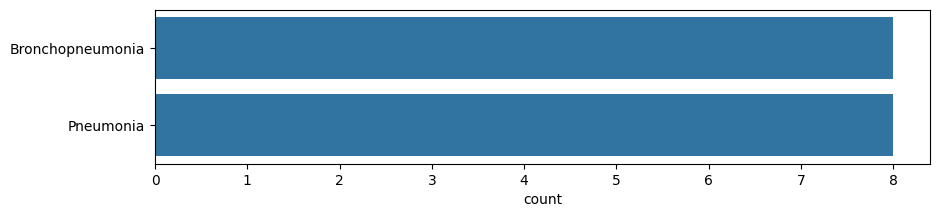

In [14]:
labels = ['Pneumonia' if label == 0 else 'Bronchopneumonia' for label in y_train]
fig = plt.subplots(figsize=(10,2))
sns.countplot(labels)

#check the labels, 0 for what?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

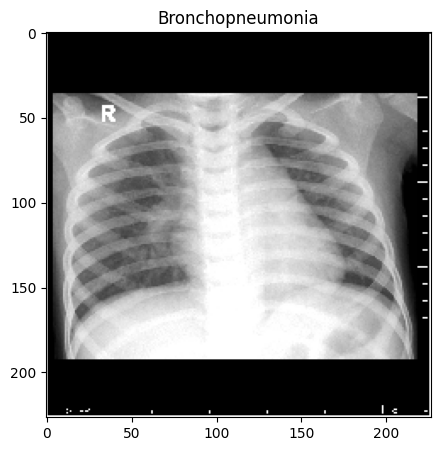

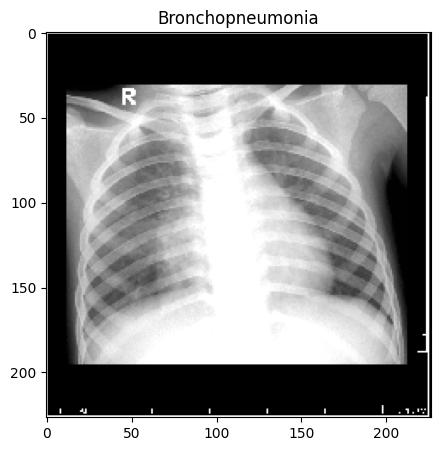

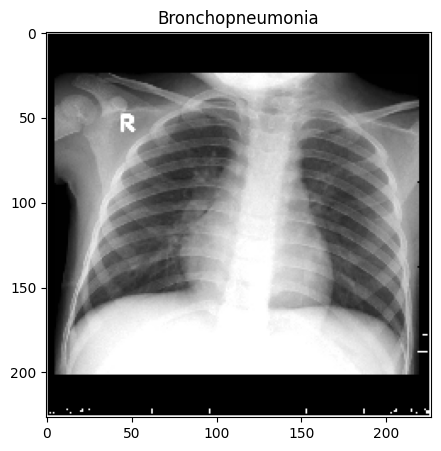

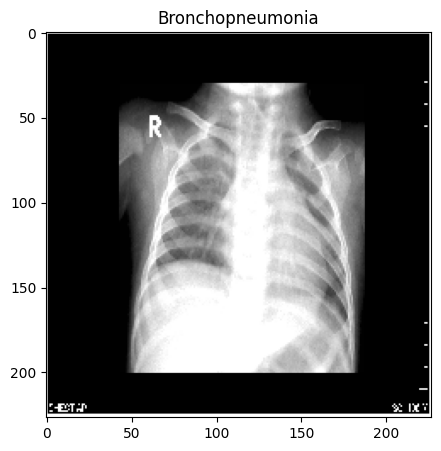

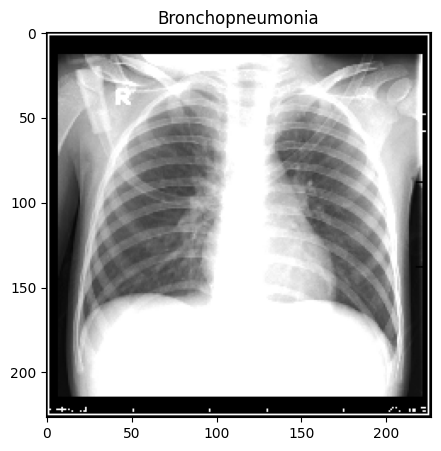

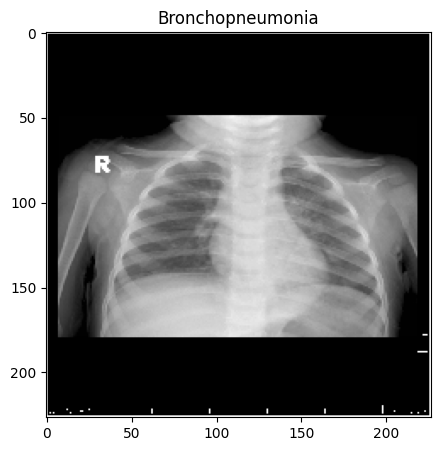

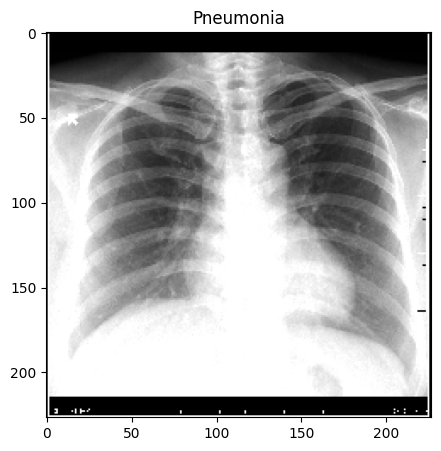

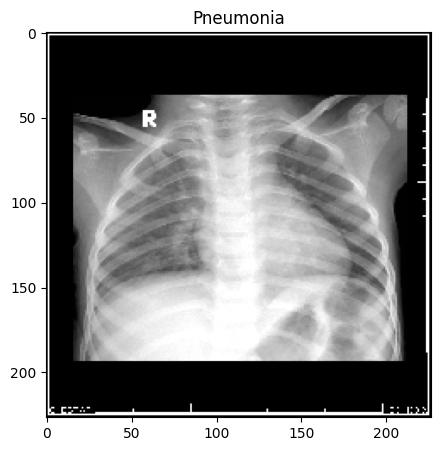

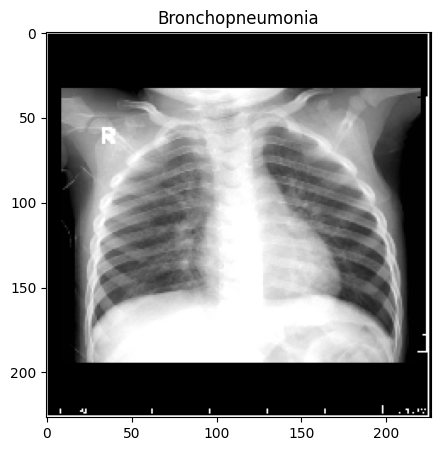

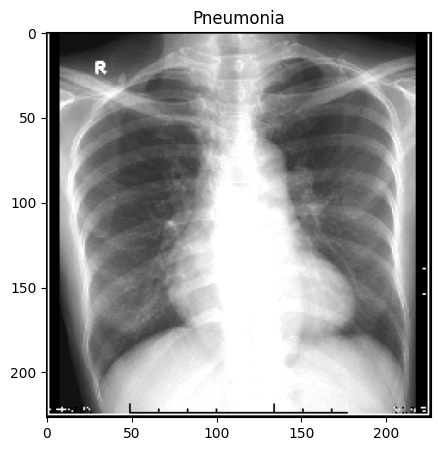

In [15]:
for augdata in range(10):
    plt.figure(figsize=(5,5))
    plt.imshow(X_train[augdata])
    plt.title(labels[augdata])

#why the green background?

In [16]:
X_train[0].shape

(227, 227, 3)

In [17]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('V10_AlexNetPneumonieBroncho.keras')

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.7 and logs.get('val_accuracy') > 0.7) and (logs.get('loss') <= 0.5 and logs.get('val_loss') <= 0.5):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False

custom_cb = CustomCallback()

In [18]:
AlexNetModel = tf.keras.models.Sequential([                                   
    tf.keras.layers.Conv2D(filters=96,
                           kernel_size=(11,11),
                           strides=(4,4),
                           activation='relu',
                           input_shape=(227,227,3),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.MaxPool2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='valid'),
    
    # tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(5,5),
                           strides=(1,1),
                           activation='relu',
                           padding="same"),

    tf.keras.layers.MaxPool2D(pool_size=(3,3),
                              strides=(2,2),
                              padding='valid'),

    # tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=384,
                           kernel_size=(3,3),
                           strides=(1,1),
                           activation='relu',
                           padding="same"),
    
    tf.keras.layers.Conv2D(filters=384,
                           kernel_size=(3,3),
                           strides=(1,1),
                           activation='relu',
                           padding="same"),
   
    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(3,3),
                           strides=(1,1),
                           activation='relu',
                           padding="same"),
    
    tf.keras.layers.MaxPool2D(pool_size=(3,3), 
                              strides=(2,2)),
    
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096,
                          activation='relu'),
    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(4096,
                          activation='relu'),
    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(1,
                          activation='sigmoid')
])

/home/isb/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-20 12:12:55.701058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 12:12:55.708943: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skippin

In [19]:
AlexNetModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,320,641 (222.48 MB)

 Trainable params: 58,303,041 (222.41 MB)

 Non-trainable params: 17,600 (68.75 KB)

In [20]:
AlexNetModel.compile(loss='binary_crossentropy',
                       optimizer=tf.optimizers.Adam(),
                       metrics=['accuracy'])

In [21]:
hist = AlexNetModel.fit(
    train_set,
    validation_data = test_set, #harusnya val_set
    epochs = 32,
    callbacks=[custom_cb, checkpoint_cb])

Epoch 1/32


/home/isb/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 914ms/step - accuracy: 0.4106 - loss: 2.0038 - val_accuracy: 0.4231 - val_loss: 169.2404
Epoch 2/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6418 - loss: 3.2921 - val_accuracy: 0.4231 - val_loss: 179.4298
Epoch 3/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5623 - loss: 2.6848 - val_accuracy: 0.4231 - val_loss: 266.2114
Epoch 4/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6993 - loss: 2.3586 - val_accuracy: 0.4231 - val_loss: 200.9133
Epoch 5/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7288 - loss: 1.0640 - val_accuracy: 0.4231 - val_loss: 223.1222
Epoch 6/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6642 - loss: 1.2197 - val_accuracy: 0.4231 - val_loss: 149.9052
Epoch 7/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6772 - loss: 1.0598 - val_accuracy: 0.4231 - val_loss: 90.1632
Epoch 8/32
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8157 - loss: 0.5146 - val_accuracy: 0.4231 - val_loss: 39.1541
Epoch

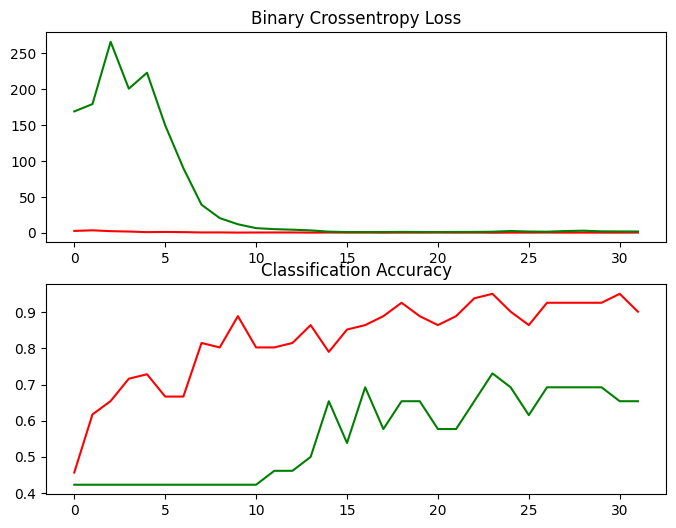

In [22]:
plt.figure(figsize=(8, 6)) 

plt.subplot(211)
plt.title('Binary Crossentropy Loss')
plt.plot(hist.history['loss'], color = 'red', label ='train')
plt.plot(hist.history['val_loss'], color = 'green', label ='val')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color = 'red', label ='train')
plt.plot(hist.history['val_accuracy'], color = 'green', label ='test')

plt.show()

Make Predictions

In [86]:
val_datagen = ImageDataGenerator(rescale=1./255)

# harusnya test_set
val_set = val_datagen.flow_from_directory(val_dir,
                                          batch_size = 16,
                                          classes = ['Pneumonia','Bronchopneumonia'],
                                          target_size = IMG_SIZE,
                                          class_mode='binary')

# for batch in train_set:
#     X_val, y_val = batch
#     break #Exit loop after processing the first batch
X_val, y_val = next(val_set)

Found 33 images belonging to 2 classes.


In [87]:
print('Loss of the model is - ', AlexNetModel.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', AlexNetModel.evaluate(X_val, y_val)[1]*100,'%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9375 - loss: 0.9908
Loss of the model is -  0.9908317923545837
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9375 - loss: 0.9908
Accuracy of the model is -  93.75 %


In [88]:
predicted_probabilities = AlexNetModel.predict(X_val)
predicted_classes = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_classes = predicted_classes.reshape(1, -1)[0]
predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [89]:
predicted_probabilities = AlexNetModel.predict(X_test)
predicted_test = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_test = predicted_classes.reshape(1, -1)[0]
predicted_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [90]:
print(np.unique(predicted_test))

[0 1]


In [91]:
print(classification_report(y_val, predicted_classes, target_names = ['Pneumonia (Class 0)','Bronchopneumonia (Class 1)']))

                            precision    recall  f1-score   support

       Pneumonia (Class 0)       1.00      0.83      0.91         6
Bronchopneumonia (Class 1)       0.91      1.00      0.95        10

                  accuracy                           0.94        16
                 macro avg       0.95      0.92      0.93        16
              weighted avg       0.94      0.94      0.94        16



In [92]:
print(len(y_test))
print(len(predicted_test))

16
16


In [93]:
print(classification_report(y_test, predicted_test, target_names = ['Pneumonia (Class 0)','Bronchopneumonia (Class 1)']))

                            precision    recall  f1-score   support

       Pneumonia (Class 0)       0.20      0.14      0.17         7
Bronchopneumonia (Class 1)       0.45      0.56      0.50         9

                  accuracy                           0.38        16
                 macro avg       0.33      0.35      0.33        16
              weighted avg       0.34      0.38      0.35        16



In [94]:
print('Confusion Matrix\n')
matrix = confusion_matrix(y_val, predicted_classes)
print(matrix)

Confusion Matrix

[[ 5  1]
 [ 0 10]]


In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score
precision = precision_score(y_val, predicted_classes)
recall = recall_score(y_val, predicted_classes)
f1 = f1_score(y_val, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9090909090909091
Recall: 1.0
F1 Score: 0.9523809523809523


In [96]:
correct = np.nonzero(predicted_classes == y_val)[0]
incorrect = np.nonzero(predicted_classes != y_val)[0]
print(len(correct), len(incorrect))

15 1


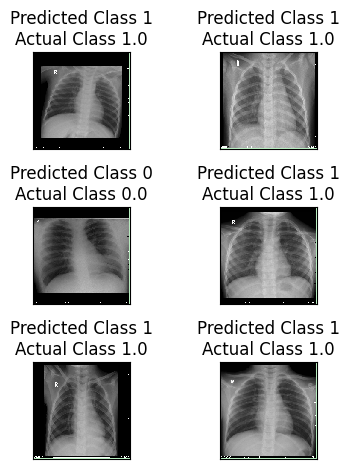

In [97]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()
    i += 1

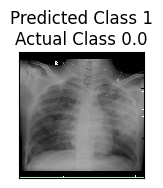

In [98]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()